,Metric,Value
0,Total documents,95
1,Total pages,4313
2,Total words,1419553
3,Docs with deconstruction content,35 (36.8%)
4,Total deconstruction words,63426
5,Deconstruction share of corpus (weighted),4.47%
6,Year range (min–max),2006–2026
7,Median year,2023
8,Concentration: docs for 50% of decon words,6
9,Concentration: docs for 80% of decon words,13


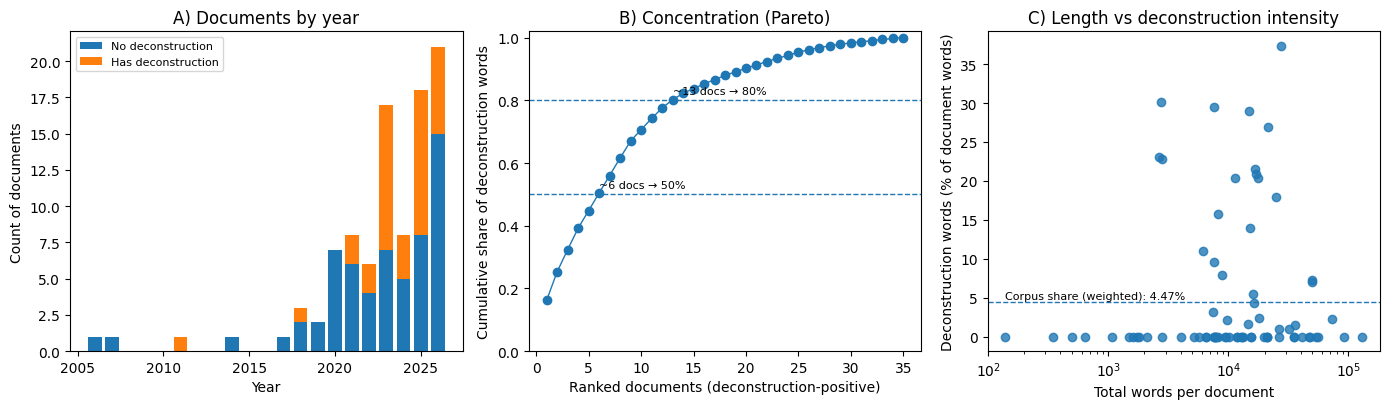

Saved outputs:
 - /content/Table_F1_corpus_deconstruction_summary.csv
 - /content/Figure_F1_corpus_deconstruction_composite.png


In [5]:
# ============================
# Table F1 + Figure F1 (Composite)
# Clarifies corpus-weighted vs within-document deconstruction intensity
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ---- Update paths if needed ----
PATH_EXCEL = "/content/drive/MyDrive/ACTIVE/AU_deconstruction_domain/Governance/PDF_Deconstruction_Analysis_20260216_230055.xlsx"

# ---- Load Excel ----
xls = pd.ExcelFile(PATH_EXCEL)

# Required sheets (as per your workbook)
df_sum   = pd.read_excel(xls, sheet_name="Complete Summary")
df_stats = pd.read_excel(xls, sheet_name="Statistics")

# ---- Standardise / clean ----
df = df_sum.copy()

# numeric conversions (robust)
for col in ["Year", "Total Words", "Deconstruction Words", "Deconstruction %", "Pages"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# handle missing deconstruction words
if "Deconstruction Words" in df.columns:
    df["Deconstruction Words"] = df["Deconstruction Words"].fillna(0)

# boolean column
if "Has Deconstruction" in df.columns:
    df["Has Deconstruction"] = df["Has Deconstruction"].astype(str).str.lower().isin(["true", "1", "yes", "y"])
else:
    # fall back: infer from deconstruction words
    df["Has Deconstruction"] = df["Deconstruction Words"] > 0

# ---- Optional: infer state/jurisdiction (best-effort, may remain Unknown) ----
state_map = {
    "NSW": [r"new south wales", r"\bnsw\b"],
    "VIC": [r"victoria", r"\bvic\b"],
    "QLD": [r"queensland", r"\bqld\b"],
    "WA":  [r"western australia", r"\bwa\b"],
    "SA":  [r"south australia", r"\bsa\b"],
    "TAS": [r"tasmania", r"\btas\b"],
    "ACT": [r"australian capital territory", r"\bact\b", r"canberra"],
    "NT":  [r"northern territory", r"\bnt\b"],
}

def infer_state(text):
    t = str(text).lower()
    for code, pats in state_map.items():
        for p in pats:
            if re.search(p, t):
                return code
    return "Unknown"

# Build a text field from likely metadata columns, if present
meta_cols = [c for c in ["Publisher", "Title", "Filename", "Source", "URL"] if c in df.columns]
if meta_cols:
    df["_meta_text"] = df[meta_cols].fillna("").astype(str).agg(" ".join, axis=1)
    df["State_inferred"] = df["_meta_text"].apply(infer_state)
else:
    df["State_inferred"] = "Unknown"

# ---- Build Table F1 metrics ----
# Stats sheet dict (if present)
stats = df_stats.dropna(subset=["Metric"]).copy()
stats_dict = dict(zip(stats["Metric"].astype(str), stats["Value"]))

# Corpus totals (computed, used for reference lines)
total_docs = len(df)
total_words = float(df["Total Words"].sum()) if "Total Words" in df.columns else np.nan
total_decon_words = float(df["Deconstruction Words"].sum()) if "Deconstruction Words" in df.columns else np.nan

# Corpus-weighted share (%)
corpus_share = (total_decon_words / total_words) * 100 if total_words and total_words > 0 else np.nan

# Deconstruction-positive subset for concentration
df_pos = df[df["Deconstruction Words"] > 0].sort_values("Deconstruction Words", ascending=False).copy()

if len(df_pos) > 0:
    cum = df_pos["Deconstruction Words"].cumsum() / df_pos["Deconstruction Words"].sum()
    # docs to reach 50% and 80%
    top50 = int((cum < 0.5).sum()) + 1
    top80 = int((cum < 0.8).sum()) + 1
else:
    top50, top80 = np.nan, np.nan

# Year metrics
year_min = int(np.nanmin(df["Year"])) if "Year" in df.columns and df["Year"].notna().any() else np.nan
year_max = int(np.nanmax(df["Year"])) if "Year" in df.columns and df["Year"].notna().any() else np.nan
year_median = int(np.nanmedian(df["Year"])) if "Year" in df.columns and df["Year"].notna().any() else np.nan

# Max within-document deconstruction intensity
max_doc_decon = float(df["Deconstruction %"].max()) if "Deconstruction %" in df.columns and df["Deconstruction %"].notna().any() else np.nan

# State inference summary
state_counts = df["State_inferred"].value_counts()
identified = int(state_counts.drop(index=["Unknown"], errors="ignore").sum())
unknown = int(state_counts.get("Unknown", 0))

# Prefer stats sheet for some values if it matches; else fall back to computed
# (This avoids surprises if the workbook already defines these precisely.)
table_rows = [
    ("Total documents", stats_dict.get("Total Documents", total_docs)),
    ("Total pages", stats_dict.get("Total Pages", int(df["Pages"].sum()) if "Pages" in df.columns and df["Pages"].notna().any() else np.nan)),
    ("Total words", stats_dict.get("Total Words", int(total_words) if not np.isnan(total_words) else np.nan)),
    ("Docs with deconstruction content", f'{stats_dict.get("Documents with Deconstruction Content", int(df["Has Deconstruction"].sum()))} ({stats_dict.get("Deconstruction Coverage Rate", f"{(df['Has Deconstruction'].mean()*100):.2f}%")})'),
    ("Total deconstruction words", stats_dict.get("Total Deconstruction Words", int(total_decon_words) if not np.isnan(total_decon_words) else np.nan)),
    ("Deconstruction share of corpus (weighted)", stats_dict.get("Deconstruction as % of Corpus", f"{corpus_share:.2f}%")),
    ("Year range (min–max)", f"{year_min}–{year_max}"),
    ("Median year", year_median),
    ("Concentration: docs for 50% of decon words", top50),
    ("Concentration: docs for 80% of decon words", top80),
    ("Max deconstruction intensity (single doc, unweighted)", f"{max_doc_decon:.2f}%"),
    ("State identified (best-effort) vs Unknown", f"{identified} vs {unknown}"),
]

table_f1 = pd.DataFrame(table_rows, columns=["Metric", "Value"])
display(table_f1)

# Save table to CSV
OUT_TABLE = "/content/Table_F1_corpus_deconstruction_summary.csv"
table_f1.to_csv(OUT_TABLE, index=False)

# ---- Build Figure F1 (3-panel composite) ----

# Panel A: docs by year (stacked)
if "Year" in df.columns and df["Year"].notna().any():
    years = np.sort(df["Year"].dropna().unique())
    counts_decon = [int(df[(df["Year"] == y) & (df["Has Deconstruction"])].shape[0]) for y in years]
    counts_nodec = [int(df[(df["Year"] == y) & (~df["Has Deconstruction"])].shape[0]) for y in years]
else:
    years = np.array([])
    counts_decon, counts_nodec = [], []

# Panel B: Pareto curve on deconstruction-positive docs
if len(df_pos) > 0:
    x_rank = np.arange(1, len(df_pos) + 1)
    y_cum = (df_pos["Deconstruction Words"].cumsum() / df_pos["Deconstruction Words"].sum()).values
else:
    x_rank = np.array([])
    y_cum = np.array([])

# Panel C: scatter total words vs within-document decon %
scatter_df = df.dropna(subset=["Total Words", "Deconstruction %"]).copy()

plt.figure(figsize=(14, 4.2))

# A) Documents by year
ax1 = plt.subplot(1, 3, 1)
if len(years) > 0:
    ax1.bar(years, counts_nodec, label="No deconstruction")
    ax1.bar(years, counts_decon, bottom=counts_nodec, label="Has deconstruction")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Count of documents")
    ax1.legend(fontsize=8)
else:
    ax1.text(0.5, 0.5, "Year metadata not available", ha="center", va="center")
ax1.set_title("A) Documents by year")

# B) Concentration (Pareto)
ax2 = plt.subplot(1, 3, 2)
if len(x_rank) > 0:
    ax2.plot(x_rank, y_cum, marker="o", linewidth=1)
    ax2.axhline(0.5, linestyle="--", linewidth=1)
    ax2.axhline(0.8, linestyle="--", linewidth=1)
    ax2.set_xlabel("Ranked documents (deconstruction-positive)")
    ax2.set_ylabel("Cumulative share of deconstruction words")
    ax2.set_ylim(0, 1.02)
    ax2.text(top50, 0.52, f"~{top50} docs → 50%", fontsize=8)
    ax2.text(top80, 0.82, f"~{top80} docs → 80%", fontsize=8)
else:
    ax2.text(0.5, 0.5, "No deconstruction-positive docs found", ha="center", va="center")
ax2.set_title("B) Concentration (Pareto)")

# C) Length vs deconstruction intensity (clarified)
ax3 = plt.subplot(1, 3, 3)
if len(scatter_df) > 0:
    ax3.scatter(scatter_df["Total Words"], scatter_df["Deconstruction %"], alpha=0.8)
    ax3.set_xscale("log")  # helps when doc lengths vary a lot
    ax3.set_xlabel("Total words per document")
    ax3.set_ylabel("Deconstruction words (% of document words)")
    # add corpus-level reference line (weighted)
    if not np.isnan(corpus_share):
        ax3.axhline(corpus_share, linestyle="--", linewidth=1)
        ax3.text(
            scatter_df["Total Words"].min(),
            corpus_share + 0.3,
            f"Corpus share (weighted): {corpus_share:.2f}%",
            fontsize=8
        )
else:
    ax3.text(0.5, 0.5, "Insufficient data for scatter", ha="center", va="center")
ax3.set_title("C) Length vs deconstruction intensity")

plt.tight_layout()

OUT_FIG = "/content/Figure_F1_corpus_deconstruction_composite.png"
plt.savefig(OUT_FIG, dpi=300, bbox_inches="tight")
plt.show()

print("Saved outputs:")
print(" -", OUT_TABLE)
print(" -", OUT_FIG)